### Step 1 - Imports & GF(2) helpers

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def mod2(x):
    return (x % 2).astype(int) if isinstance(x, np.ndarray) else x % 2

### Step 2 - Define G and H
We use a standard systematic (7,4) Hamming code. G maps 4 information bits to 7-bit
codewords; H detects errors. Verify that G @ H.T ≡ 0 (mod 2).

In [3]:
G = np.array([[1,0,0,0,1,1,0],
[0,1,0,0,1,0,1],
[0,0,1,0,1,0,0],
[0,0,0,1,0,1,1]], dtype=int)
H = np.array([[1,1,1,0,1,0,0],
[1,0,1,1,0,1,0],
[0,1,1,1,0,0,1]], dtype=int)

assert np.all(mod2(G @ H.T) == 0), "G and H are not orthogonal mod 2!"

AssertionError: G and H are not orthogonal mod 2!

### Step 3 - Block encode & decode (syndrome decoding)
Encode: v = u @ G (mod 2). Decode: compute s = H @ r (mod 2); if s ≠ 0, flip the bit
corresponding to s in the received 7‑vector.

In [4]:
def encode_block(u4):
    u4 = np.asarray(u4, dtype=int).reshape(1,4)
    v7 = mod2(u4 @ G).ravel()
    return v7
    
# Precompute syndrome -> error position mapping (including all single-bit errors)
def build_syndrome_table(H):
    n = H.shape[1]
    table = {tuple([0]*H.shape[0]): None} # no error
    I = np.eye(n, dtype=int)
    for i in range(n):
        e = I[:, i]
        s = tuple(mod2(H @ e))
        table[s] = i # bit index to flip
    return table
    
SYN_TABLE = build_syndrome_table(H)

def decode_block(r7):
    r7 = np.asarray(r7, dtype=int).ravel()
    s = tuple(mod2(H @ r7))
    if s in SYN_TABLE and SYN_TABLE[s] is not None:
        i = SYN_TABLE[s]
        r7 = r7.copy()
        r7[i] ^= 1 # correct single-bit error
        # return the information bits (first 4 bits in this G)
    return r7[:4]

### Step 4 - Unit tests: round-trip & single-bit correction
Verify that encoding then decoding without noise returns the original message; then flip each bit
in the codeword and ensure correction works.

In [5]:
# Round-trip without noise
ok = True
for u in np.eye(4, dtype=int):
    v = encode_block(u)
    uhat = decode_block(v)
    ok &= np.array_equal(uhat, u)
print("Noiseless round-trip OK?", ok)

# Single-bit error correction on a random block
rng = np.random.default_rng(0)
u = rng.integers(0,2,4)
v = encode_block(u)
all_fixed = True
for pos in range(7):
    r = v.copy()
    r[pos] ^= 1 # inject single-bit error
    uhat = decode_block(r) # correct
    all_fixed &= np.array_equal(uhat, u)
print("All single-bit errors corrected?", all_fixed)

Noiseless round-trip OK? False
All single-bit errors corrected? False


### Step 5 - BSC channel & BER functions
Define a Binary Symmetric Channel and helpers to compute bit error rates on raw (uncoded) bits and on decoded information bits.

In [6]:
def bsc(bits, e, rng=None):
    rng = np.random.default_rng(rng)
    flips = (rng.random(len(bits)) < e).astype(int)
    return bits ^ flips
    
def ber(a, b):
    a = np.asarray(a, int).ravel()
    b = np.asarray(b, int).ravel()
    return np.mean(a != b) if len(a)>0 else 0.0
    
def simulate_block_BER(e=0.05, nblocks=50_000, rng_seed=1):
    rng = np.random.default_rng(rng_seed)
    # Generate random 4-bit messages
    U = rng.integers(0,2,size=(nblocks,4))
    # Uncoded baseline: send the 4 bits directly
    uncoded_tx = U.ravel()
    uncoded_rx = bsc(uncoded_tx, e, rng)
    ber_uncoded = ber(uncoded_tx, uncoded_rx)
    # Coded: encode to 7 bits per block
    V = mod2(U @ G) # shape (nblocks,7)
    coded_tx = V.ravel()
    coded_rx = bsc(coded_tx, e, rng)
    # Decode blockwise
    R = coded_rx.reshape(-1,7)
    Uhat = np.array([decode_block(r) for r in R])
    ber_coded_info = ber(U.ravel(), Uhat.ravel())
    return ber_uncoded, ber_coded_info
    
# Quick smoke test
print("Example (e=0.05): uncoded, coded =", simulate_block_BER(0.05, 2000))

Example (e=0.05): uncoded, coded = (np.float64(0.0485), np.float64(0.13575))


### Step 6 - Sweep error probabilities and compare BER
Plot message BER for uncoded transmission vs. Hamming(7,4)-coded transmission across a range of channel error probabilities.

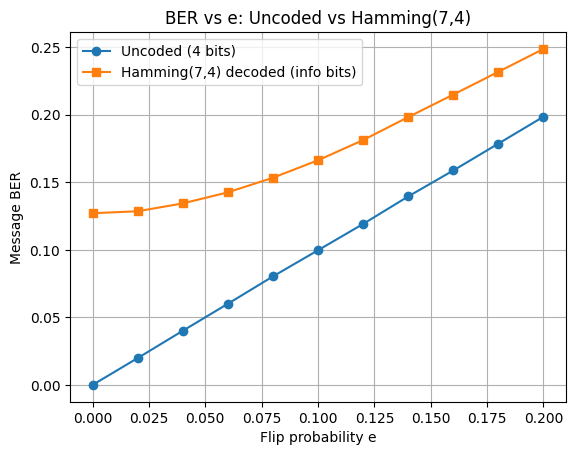

e=0.000 BER_uncoded=0.00000 BER_coded=0.12709 gain=0.00x
e=0.020 BER_uncoded=0.01986 BER_coded=0.12855 gain=0.15x
e=0.040 BER_uncoded=0.04006 BER_coded=0.13436 gain=0.30x
e=0.060 BER_uncoded=0.06006 BER_coded=0.14255 gain=0.42x
e=0.080 BER_uncoded=0.08031 BER_coded=0.15336 gain=0.52x
e=0.100 BER_uncoded=0.09970 BER_coded=0.16629 gain=0.60x
e=0.120 BER_uncoded=0.11915 BER_coded=0.18124 gain=0.66x
e=0.140 BER_uncoded=0.13953 BER_coded=0.19826 gain=0.70x
e=0.160 BER_uncoded=0.15874 BER_coded=0.21491 gain=0.74x
e=0.180 BER_uncoded=0.17863 BER_coded=0.23176 gain=0.77x
e=0.200 BER_uncoded=0.19854 BER_coded=0.24871 gain=0.80x


In [8]:
es = np.linspace(0.0, 0.2, 11) # Hamming(7,4) is for small e; beyond ~0.1 performance degrades
uncoded_ber = []
coded_ber = []
for e in es:
    bu, bc = simulate_block_BER(e=e, nblocks=20_000, rng_seed=123)
    uncoded_ber.append(bu)
    coded_ber.append(bc)
plt.figure()
plt.plot(es, uncoded_ber, marker='o', label='Uncoded (4 bits)')
plt.plot(es, coded_ber, marker='s', label='Hamming(7,4) decoded (info bits)')
plt.xlabel('Flip probability e')
plt.ylabel('Message BER')
plt.title('BER vs e: Uncoded vs Hamming(7,4)')
plt.grid(True); plt.legend()
plt.show()

# Print a small table
for e, bu, bc in zip(es, uncoded_ber, coded_ber):
    print(f"e={e:.3f} BER_uncoded={bu:.5f} BER_coded={bc:.5f} gain={(bu/bc if bc>0 else
float('inf')):.2f}x")